In [1]:
import pandas as pd
import pymc as pm
import pymc_experimental as pmx
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
from typing import Dict, Any, List, Tuple

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print("PyMC version:", pm.__version__)
print("NumPy version:", np.__version__)
print("PyMC Experimental version:", pmx.__version__)

PyMC version: 5.18.0
NumPy version: 1.26.4
PyMC Experimental version: 0.1.3



--- Running model with prior: Prior Set 1 ---


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 19 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


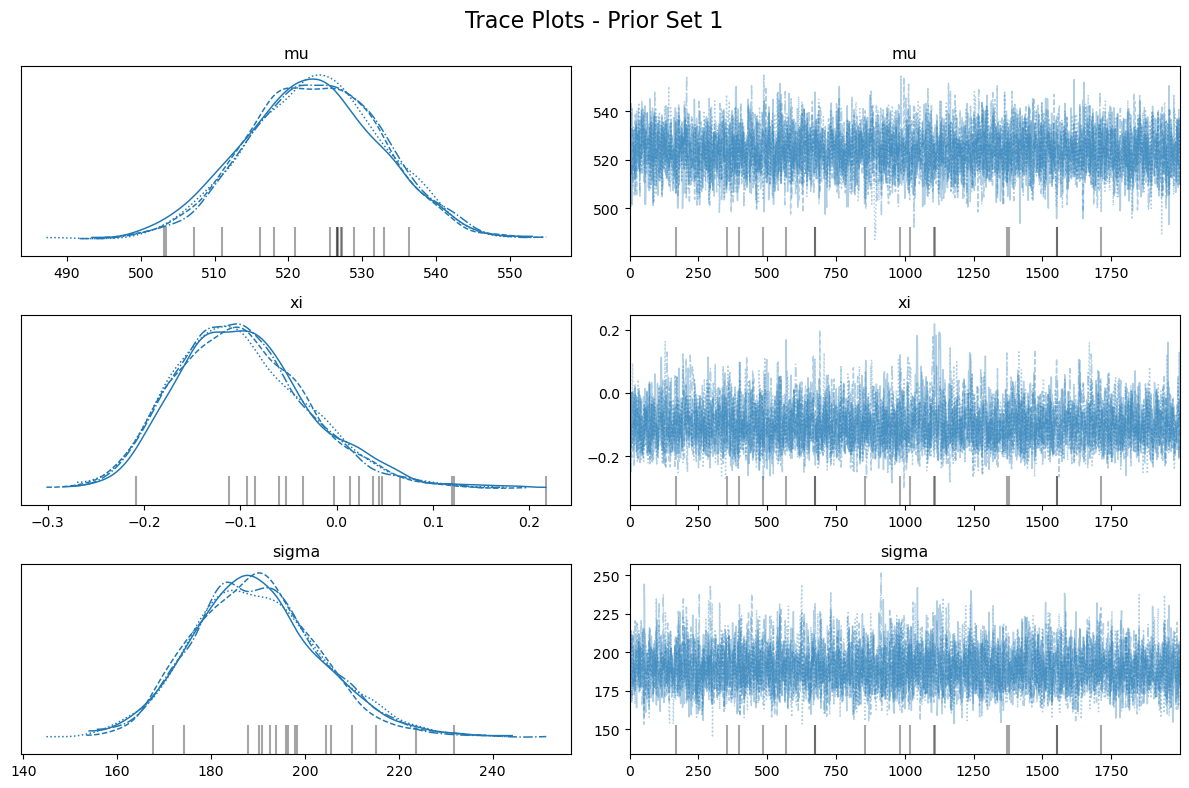

Summary for Prior Set 1 priors:
          mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu     523.492   9.198  507.209  541.588      0.137    0.097    4543.0   
sigma  189.804  13.622  165.037  215.593      0.204    0.145    4529.0   
xi      -0.098   0.069   -0.218    0.033      0.001    0.001    3736.0   

       ess_tail  r_hat  
mu       4423.0    1.0  
sigma    4718.0    1.0  
xi       3121.0    1.0  


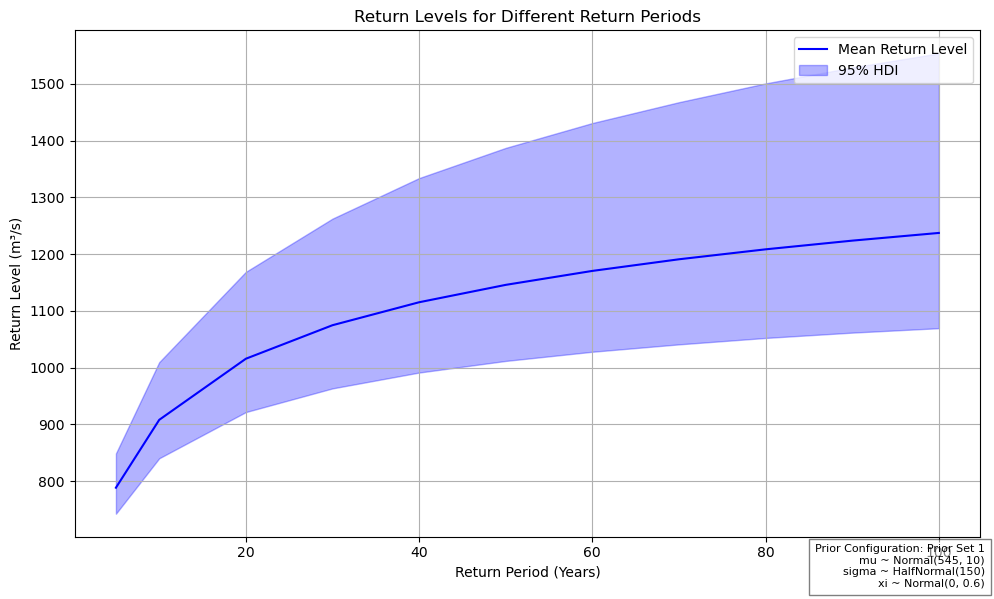


--- Running model with prior: Prior Set 2 ---


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 19 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


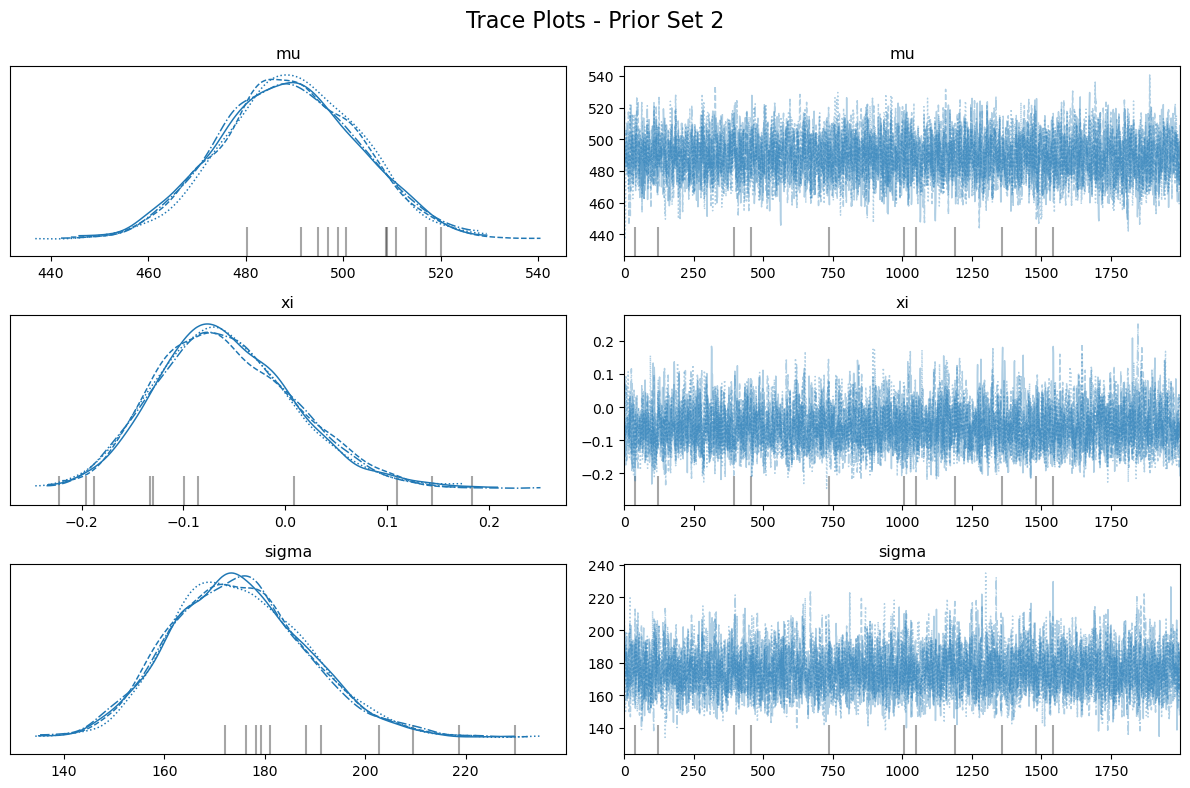

Summary for Prior Set 2 priors:
          mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu     489.126  14.119  461.368  514.228      0.230    0.163    3756.0   
sigma  174.895  13.394  150.202  199.835      0.222    0.157    3640.0   
xi      -0.058   0.067   -0.181    0.066      0.001    0.001    3797.0   

       ess_tail  r_hat  
mu       4250.0    1.0  
sigma    4536.0    1.0  
xi       4168.0    1.0  


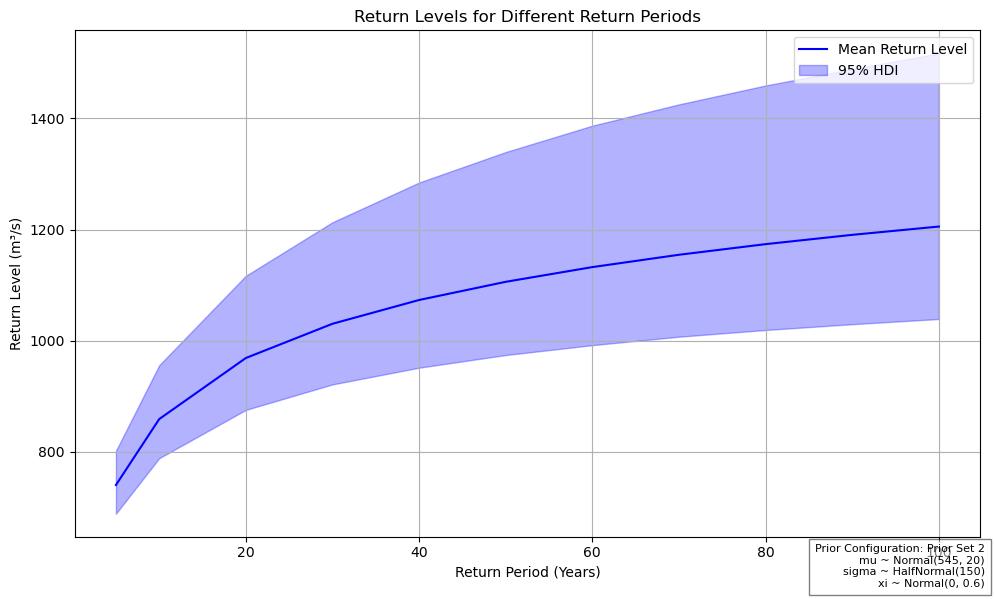


--- Running model with prior: Prior Set 3 ---


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


In [ ]:
########## Prior Sensitivity Analysis ##############

def load_and_preprocess_data(filepath: str, exclude_years: List[int] = None) -> np.ndarray:
    """
    Load discharge data from a CSV file, parse dates, exclude specific years,
    and compute annual maximum discharge.

    Parameters:
    - filepath (str): Path to the CSV file.
    - exclude_years (list, optional): Years to exclude from the dataset.

    Returns:
    - np.ndarray: Annual maximum discharge values.
    """
    if exclude_years is None:
        exclude_years = [1920, 2024]

    try:
        data = pd.read_csv(filepath)
    except FileNotFoundError:
        raise FileNotFoundError(f"File not found: {filepath}")

    # Parse dates
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data['Year'] = data['Date'].dt.year

    # Exclude specified years
    data = data[~data['Year'].isin(exclude_years)]

    # Compute annual maximum discharge
    annual_max = data.groupby('Year')['Discharge (m³/s)'].max().values

    return annual_max

def build_gev_model(data: np.ndarray,
                    priors: Dict[str, Dict[str, Any]] = None) -> pm.Model:
    """
    Build a Bayesian GEV model using PyMC with specified priors.

    Parameters:
    - data (np.ndarray): Annual maximum discharge values.
    - priors (dict, optional): Dictionary specifying priors for 'mu', 'sigma', and 'xi'.

    Returns:
    - pm.Model: The constructed PyMC model.
    """
    if priors is None:
        # Default priors
        priors = {
            'mu': {'mu': 600, 'sigma': 10, 'initval': np.mean(data)},
            'sigma': {'sigma': 10, 'initval': np.std(data)},
            'xi': {'mu': 0, 'sigma': 0.1, 'initval': 0}
        }

    with pm.Model() as model:
        # Priors
        mu = pm.Normal("mu", mu=priors['mu']['mu'], sigma=priors['mu']['sigma'],
                      initval=priors['mu']['initval'])
        sigma = pm.HalfNormal("sigma", sigma=priors['sigma']['sigma'],
                             initval=priors['sigma']['initval'])
        xi = pm.Normal("xi", mu=priors['xi']['mu'], sigma=priors['xi']['sigma'],
                      initval=priors['xi']['initval'])

        # GEV likelihood
        gev = pmx.GenExtreme("gev", mu=mu, sigma=sigma, xi=xi, observed=data)

    return model

def sample_posterior(model: pm.Model,
                    draws: int = 2000,
                    chains: int = 4,
                    tune: int = 500,
                    target_accept: float = 0.98) -> az.InferenceData:
    """
    Sample from the posterior distribution of the model.

    Parameters:
    - model (pm.Model): The PyMC model.
    - draws (int): Number of posterior samples.
    - chains (int): Number of MCMC chains.
    - tune (int): Number of tuning steps.
    - target_accept (float): Target acceptance rate for the sampler.

    Returns:
    - az.InferenceData: The sampled posterior as an ArviZ InferenceData object.
    """
    with model:
        trace = pm.sample(draws=draws, chains=chains, tune=tune, target_accept=target_accept)
    return trace

def compute_return_levels(trace: az.InferenceData,
                         return_periods: np.ndarray) -> Dict[str, np.ndarray]:
    """
    Compute return levels for specified return periods using posterior samples.

    Parameters:
    - trace (az.InferenceData): The sampled posterior.
    - return_periods (np.ndarray): Array of return periods (years).

    Returns:
    - dict: Contains mean return levels and their HDI bounds.
    """
    # Extract posterior samples
    mu = trace.posterior['mu'].values  # Shape: (chains, draws)
    sigma = trace.posterior['sigma'].values
    xi = trace.posterior['xi'].values

    # Flatten the samples across chains and draws
    mu = mu.flatten()      # Shape: (total_samples,)
    sigma = sigma.flatten()
    xi = xi.flatten()

    rp = np.array(return_periods)  # Shape: (11,) including 5-year return period

    # Reshape parameters for broadcasting
    mu = mu[:, np.newaxis]          # Shape: (total_samples, 1)
    sigma = sigma[:, np.newaxis]    # Shape: (total_samples, 1)
    xi = xi[:, np.newaxis]          # Shape: (total_samples, 1)
    rp = rp[np.newaxis, :]          # Shape: (1, 11)

    # Calculate the quantile (return level) using the GEV formula
    with np.errstate(divide='ignore', invalid='ignore'):
        term = -np.log(1 - 1 / rp)
        return_levels = mu + (sigma / xi) * (term ** (-xi) - 1)

    # Handle cases where xi is approximately zero (Gumbel distribution)
    # Using a tolerance to avoid floating point issues
    gumbel_mask = np.abs(xi) < 1e-6
    return_levels = np.where(
        gumbel_mask,
        mu - sigma * np.log(term),
        return_levels
    )

    # Compute statistics across all samples for each return period
    return_levels_mean = np.mean(return_levels, axis=0)
    hdi_lower = np.percentile(return_levels, 2.5, axis=0)
    hdi_upper = np.percentile(return_levels, 97.5, axis=0)

    return {
        'mean': return_levels_mean,
        'hdi_lower': hdi_lower,
        'hdi_upper': hdi_upper
    }

def plot_return_levels(return_periods: np.ndarray,
                      return_levels_stats: Dict[str, np.ndarray],
                      prior_info: str = ""):
    """
    Plot return levels with their 95% HDI and display prior information.

    Parameters:
    - return_periods (np.ndarray): Array of return periods (years).
    - return_levels_stats (dict): Dictionary containing mean, hdi_lower, and hdi_upper.
    - prior_info (str): String containing prior parameter details for annotation.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(return_periods, return_levels_stats['mean'], label='Mean Return Level', color='blue')
    plt.fill_between(return_periods, return_levels_stats['hdi_lower'], return_levels_stats['hdi_upper'],
                     color='blue', alpha=0.3, label='95% HDI')
    plt.xlabel('Return Period (Years)')
    plt.ylabel('Return Level (m³/s)')
    plt.title('Return Levels for Different Return Periods')

    # Add prior information as a text box on the plot
    if prior_info:
        plt.gcf().text(0.99, 0.01, prior_info, fontsize=8,
                       verticalalignment='bottom', horizontalalignment='right',
                       bbox=dict(facecolor='white', alpha=0.5))

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_different_priors(data: np.ndarray,
                         return_periods: np.ndarray,
                         prior_sets: List[Tuple[str, Dict[str, Dict[str, Any]]]]):
    """
    Run the GEV model with different prior configurations to understand model behavior.

    Parameters:
    - data (np.ndarray): Annual maximum discharge values.
    - return_periods (np.ndarray): Array of return periods (years).
    - prior_sets (list of tuples): Each tuple contains a name for the prior set and
      a dictionary specifying priors for 'mu', 'sigma', and 'xi'.

    Returns:
    - results (dict): Dictionary containing results for each prior set.
    """
    results = {}

    for prior_name, priors in prior_sets:
        print(f"\n--- Running model with prior: {prior_name} ---")

        # Build model with specified priors
        model = build_gev_model(data, priors=priors)

        # Sample posterior
        trace = sample_posterior(model)

        # Plot trace
        az.plot_trace(trace, figsize=(12, 8))
        plt.suptitle(f'Trace Plots - {prior_name}', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Print summary
        summary = az.summary(trace, var_names=['mu', 'sigma', 'xi'])
        print(f"Summary for {prior_name} priors:")
        print(summary)

        # Compute return levels
        return_levels_stats = compute_return_levels(trace, return_periods)

        # Prepare prior information string for annotation
        prior_info = f"Prior Configuration: {prior_name}\n"
        prior_info += f"mu ~ Normal({priors['mu']['mu']}, {priors['mu']['sigma']})\n"
        prior_info += f"sigma ~ HalfNormal({priors['sigma']['sigma']})\n"
        prior_info += f"xi ~ Normal({priors['xi']['mu']}, {priors['xi']['sigma']})"

        # Plot return levels with prior information
        plot_return_levels(return_periods, return_levels_stats, prior_info=prior_info)

        # Store results
        results[prior_name] = {
            'trace': trace,
            'summary': summary,
            'return_levels': return_levels_stats,
            'priors': priors  # Store priors for potential further use
        }

    return results

def plot_comparative_return_levels(return_periods: np.ndarray,
                                  results: Dict[str, Dict[str, Any]]):
    """
    Plot and compare return levels across different priors.

    Parameters:
    - return_periods (np.ndarray): Array of return periods (years).
    - results (dict): Dictionary containing results for each prior set.
    """
    plt.figure(figsize=(12, 8))
    for prior_name, result in results.items():
        plt.plot(return_periods, result['return_levels']['mean'],
                 label=f'{prior_name} Mean', alpha=0.7)
    plt.xlabel('Return Period (Years)')
    plt.ylabel('Return Level (m³/s)')
    plt.title('Comparison of Return Levels Across Different Priors')
    plt.legend()
    plt.grid(True)

    # Prepare a string with all prior configurations
    prior_details = ""
    for prior_name, result in results.items():
        priors = result['priors']
        prior_details += f"{prior_name}:\n"
        prior_details += f"  mu ~ Normal({priors['mu']['mu']}, {priors['mu']['sigma']})\n"
        prior_details += f"  sigma ~ HalfNormal({priors['sigma']['sigma']})\n"
        prior_details += f"  xi ~ Normal({priors['xi']['mu']}, {priors['xi']['sigma']})\n\n"

    # Add prior details as a text box on the plot
    plt.gcf().text(0.99, 0.01, prior_details, fontsize=8,
                   verticalalignment='bottom', horizontalalignment='right',
                   bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

def main():
    # Configuration
    filepath = r'Bergheim_discharge.csv'  # Update this path as needed
    exclude_years = [1920, 2024]
    return_periods = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])  # Included 5-year return period

    # Load and preprocess data
    annual_max_discharge = load_and_preprocess_data(filepath, exclude_years)

    # Define different prior configurations
    prior_sets = [
        (
            "Prior Set 1",
            {
                'mu': {'mu': 545, 'sigma': 10, 'initval': np.mean(annual_max_discharge)},
                'sigma': {'sigma': 150, 'initval': np.std(annual_max_discharge)},
                'xi': {'mu': 0, 'sigma': 0.6, 'initval': 0}
            }
        ),
        (
            "Prior Set 2",
            {
                'mu': {'mu': 545, 'sigma': 20, 'initval': np.mean(annual_max_discharge)},
                'sigma': {'sigma': 150, 'initval': np.std(annual_max_discharge)},
                'xi': {'mu': 0, 'sigma': 0.6, 'initval': 0}
            }
        ),
        (
            "Prior Set 3",
            {
                'mu': {'mu': 545, 'sigma': 50, 'initval': np.mean(annual_max_discharge)},
                'sigma': {'sigma': 150, 'initval': np.std(annual_max_discharge)},
                'xi': {'mu': 0, 'sigma': 0.6, 'initval': 0}
            }
        ),
          (
            "Prior Set 4",
            {
                'mu': {'mu': 545, 'sigma': 150, 'initval': np.mean(annual_max_discharge)},
                'sigma': {'sigma': 150, 'initval': np.std(annual_max_discharge)},
                'xi': {'mu': 0, 'sigma': 0.6, 'initval': 0}
            }
        ),
          (
            "Prior Set 5",
            {
                'mu': {'mu': 545, 'sigma': 300, 'initval': np.mean(annual_max_discharge)},
                'sigma': {'sigma': 150, 'initval': np.std(annual_max_discharge)},
                'xi': {'mu': 0, 'sigma': 0.6, 'initval': 0}
            }
        ),
        (
            "Prior Set 6",
            {
                'mu': {'mu': 545, 'sigma': 400, 'initval': np.mean(annual_max_discharge)},
                'sigma': {'sigma': 150, 'initval': np.std(annual_max_discharge)},
                'xi': {'mu': 0, 'sigma': 0.6, 'initval': 0}
            }
        )
    ]

    # Run models with different priors
    results = run_different_priors(annual_max_discharge, return_periods, prior_sets)

    # Plot comparison of return levels across different priors
    plot_comparative_return_levels(return_periods, results)

    # Print comparison of return levels
    print("\nComparison of Return Levels Across Different Priors:")
    for rp in return_periods:
        print(f"\nReturn Period: {rp} years")
        for prior_name, result in results.items():
            # Find the index where return_periods == rp
            idx = np.where(return_periods == rp)[0][0]
            mean_rl = result['return_levels']['mean'][idx]
            lb = result['return_levels']['hdi_lower'][idx]
            ub = result['return_levels']['hdi_upper'][idx]
            print(f"  {prior_name}: Mean = {mean_rl:.2f}, 95% HDI = [{lb:.2f}, {ub:.2f}] m³/s")

if __name__ == "__main__":
    main()


In [18]:
##### Function Definition for Station Plots #########

def plot_return_levels(return_periods: np.ndarray,
                      return_levels_stats: Dict[str, np.ndarray],
                      prior_info: str = "",
                      alert_levels: Dict[str, float] = None,
                      alert_periods: Dict[str, float] = None):
    """
    Plot return levels with their 95% HDI, display prior information, and add alert level markers.

    Parameters:
    - return_periods (np.ndarray): Array of return periods (years).
    - return_levels_stats (dict): Dictionary containing mean, hdi_lower, and hdi_upper.
    - prior_info (str): String containing prior parameter details for annotation.
    - alert_levels (dict): Dictionary with alert level labels ('yellow', 'orange', 'red') and corresponding y-values.
    - alert_periods (dict): Dictionary with alert level labels and corresponding x-values (return periods).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(return_periods, return_levels_stats['mean'], label='Mean Return Level', color='blue')
    plt.fill_between(return_periods, return_levels_stats['hdi_lower'], return_levels_stats['hdi_upper'],
                     color='blue', alpha=0.3, label='95% HDI')
    
    # Add alert level markers if provided
    if alert_levels and alert_periods:
        alert_colors = {'yellow': 'yellow', 'orange': 'orange', 'red': 'red'}
        for i in alert_colors.keys():
             plt.scatter(alert_periods[i], alert_levels[i], color=alert_colors[i], marker='o', s=100)

    plt.xlabel('Return Period (Years)')
    plt.ylabel('Return Level (m³/s)')
    plt.title('Return Levels for Different Return Periods')

    # Add prior information as a text box on the plot
    if prior_info:
        plt.gcf().text(0.99, 0.01, prior_info, fontsize=8,
                       verticalalignment='bottom', horizontalalignment='right',
                       bbox=dict(facecolor='white', alpha=0.5))

    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def run_different_priors(data: np.ndarray,
                         return_periods: np.ndarray,
                         prior_sets: List[Tuple[str, Dict[str, Dict[str, Any]]]],
                        alert_levels: Dict[str, float] = None,
                         alert_periods: Dict[str, float] = None):
    """
    Run the GEV model with different prior configurations to understand model behavior.

    Parameters:
    - data (np.ndarray): Annual maximum discharge values.
    - return_periods (np.ndarray): Array of return periods (years).
    - prior_sets (list of tuples): Each tuple contains a name for the prior set and
      a dictionary specifying priors for 'mu', 'sigma', and 'xi'.

    Returns:
    - results (dict): Dictionary containing results for each prior set.
    """
    results = {}

    for prior_name, priors in prior_sets:
        print(f"\n--- Running model with prior: {prior_name} ---")

        # Build model with specified priors
        model = build_gev_model(data, priors=priors)

        # Sample posterior
        trace = sample_posterior(model)

        # Plot trace
        az.plot_trace(trace, figsize=(12, 8))
        plt.suptitle(f'Trace Plots - {prior_name}', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Print summary
        summary = az.summary(trace, var_names=['mu', 'sigma', 'xi'])
        print(f"Summary for {prior_name} priors:")
        print(summary)

        # Compute return levels
        return_levels_stats = compute_return_levels(trace, return_periods)

        # Prepare prior information string for annotation
        prior_info = f"Prior Configuration: {prior_name}\n"
        prior_info += f"mu ~ Normal({priors['mu']['mu']}, {priors['mu']['sigma']})\n"
        prior_info += f"sigma ~ HalfNormal({priors['sigma']['sigma']})\n"
        prior_info += f"xi ~ Normal({priors['xi']['mu']}, {priors['xi']['sigma']})"

        # Plot return levels with prior information
        plot_return_levels(return_periods, return_levels_stats, prior_info=prior_info, alert_levels=alert_levels, alert_periods=alert_periods )

        # Store results
        results[prior_name] = {
            'trace': trace,
            'summary': summary,
            'return_levels': return_levels_stats,
            'priors': priors  # Store priors for potential further use
        }

    return results





--- Running model with prior: Default Priors ---


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 19 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


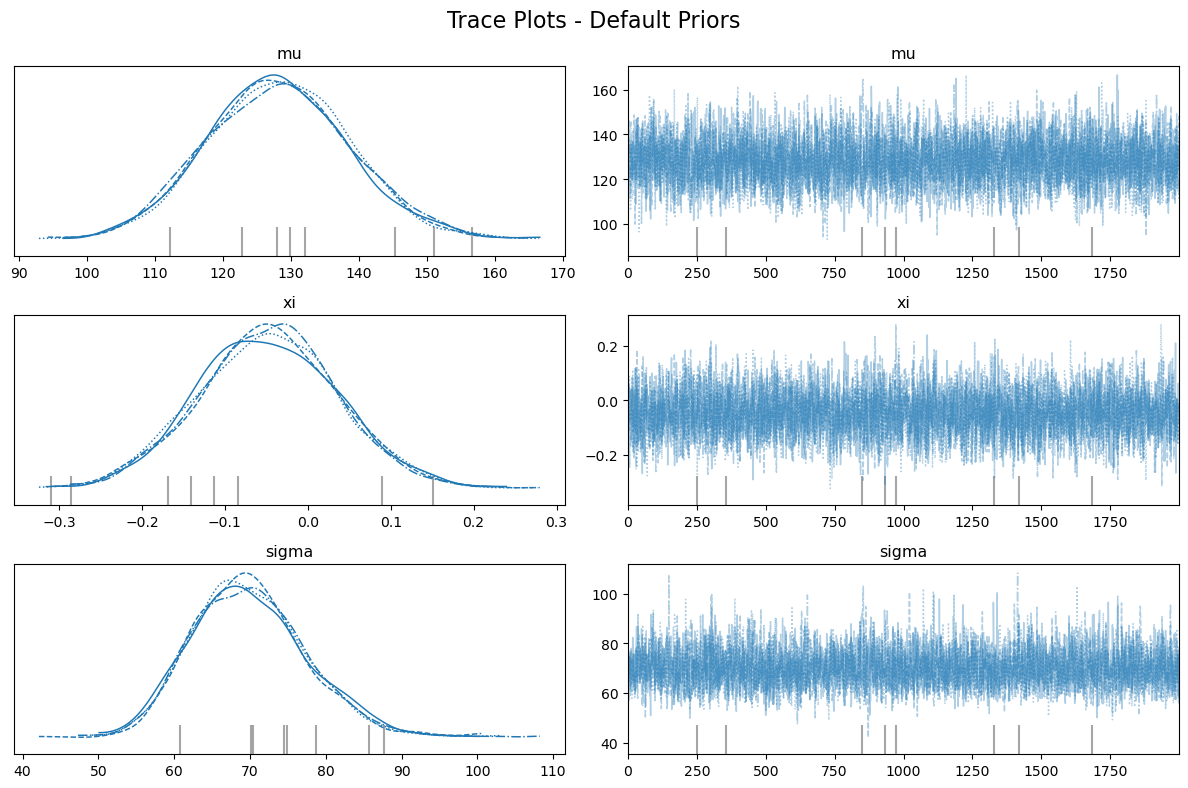

Summary for Default Priors priors:
          mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu     128.249  10.414  108.400  147.395      0.159    0.113    4291.0   
sigma   69.945   7.598   56.438   84.072      0.118    0.084    4160.0   
xi      -0.047   0.084   -0.211    0.105      0.001    0.001    4411.0   

       ess_tail  r_hat  
mu       4855.0    1.0  
sigma    4313.0    1.0  
xi       4981.0    1.0  


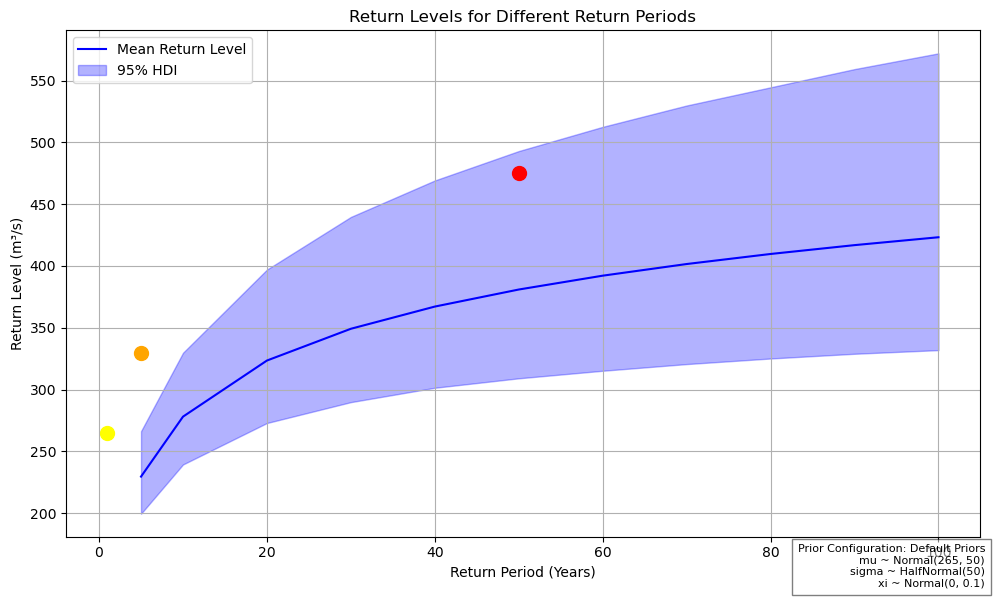

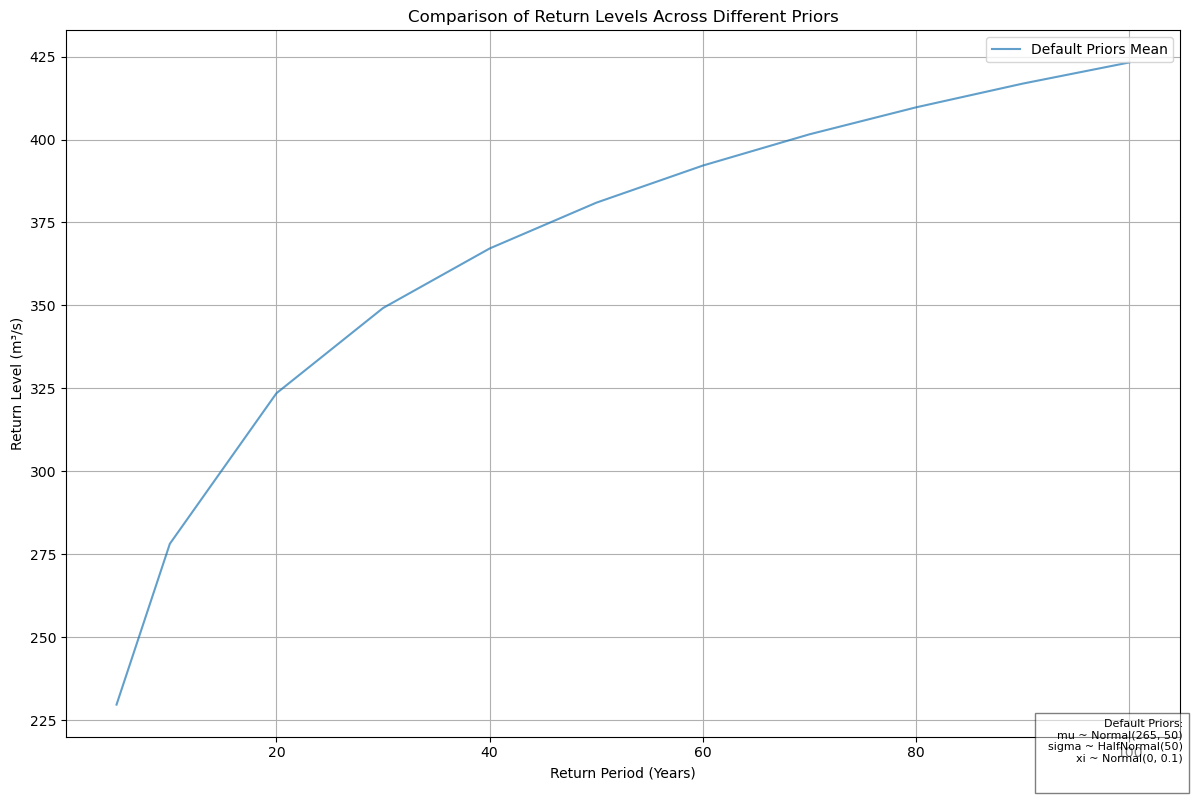


Comparison of Return Levels Across Different Priors:

Return Period: 5 years
  Default Priors: Mean = 229.66, 95% HDI = [199.65, 266.39] m³/s

Return Period: 10 years
  Default Priors: Mean = 278.15, 95% HDI = [239.46, 329.80] m³/s

Return Period: 20 years
  Default Priors: Mean = 323.53, 95% HDI = [273.00, 397.11] m³/s

Return Period: 30 years
  Default Priors: Mean = 349.22, 95% HDI = [289.88, 439.68] m³/s

Return Period: 40 years
  Default Priors: Mean = 367.17, 95% HDI = [301.50, 469.18] m³/s

Return Period: 50 years
  Default Priors: Mean = 380.97, 95% HDI = [309.16, 492.95] m³/s

Return Period: 60 years
  Default Priors: Mean = 392.17, 95% HDI = [315.26, 512.54] m³/s

Return Period: 70 years
  Default Priors: Mean = 401.59, 95% HDI = [320.66, 529.81] m³/s

Return Period: 80 years
  Default Priors: Mean = 409.72, 95% HDI = [325.17, 544.52] m³/s

Return Period: 90 years
  Default Priors: Mean = 416.87, 95% HDI = [329.00, 559.25] m³/s

Return Period: 100 years
  Default Priors: Mea

In [19]:
########## Elvarheim Station ###########

def main():
    # Configuration
    filepath = r'Elvarheim_Discharge.csv'  # Update this path as needed
    exclude_years = [1968, 2007, 2013, 2024]
    return_periods = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])  # Included 5-year return period
    alert_levels = {
        'yellow': 265,
        'orange': 330,
        'red': 475
    }
    alert_periods = {
        'yellow': 1,
        'orange': 5,
        'red': 50
    }
    # Load and preprocess data
    annual_max_discharge = load_and_preprocess_data(filepath, exclude_years)

    # Define different prior configurations
    prior_sets = [
        (
            "Default Priors",
            {
                'mu': {'mu': 265, 'sigma': 50, 'initval': np.mean(annual_max_discharge)},
                'sigma': {'sigma': 50, 'initval': np.std(annual_max_discharge)},
                'xi': {'mu': 0, 'sigma': 0.1, 'initval': 0}
            }
        ),
        
    ]

    # Run models with different priors
    results = run_different_priors(annual_max_discharge, return_periods, prior_sets, alert_levels=alert_levels, alert_periods=alert_periods)

    # Plot comparison of return levels across different priors
    plot_comparative_return_levels(return_periods, results)

    # Print comparison of return levels
    print("\nComparison of Return Levels Across Different Priors:")
    for rp in return_periods:
        print(f"\nReturn Period: {rp} years")
        for prior_name, result in results.items():
            # Find the index where return_periods == rp
            idx = np.where(return_periods == rp)[0][0]
            mean_rl = result['return_levels']['mean'][idx]
            lb = result['return_levels']['hdi_lower'][idx]
            ub = result['return_levels']['hdi_upper'][idx]
            print(f"  {prior_name}: Mean = {mean_rl:.2f}, 95% HDI = [{lb:.2f}, {ub:.2f}] m³/s")

if __name__ == "__main__":
    main()



--- Running model with prior: Default Priors ---


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 19 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


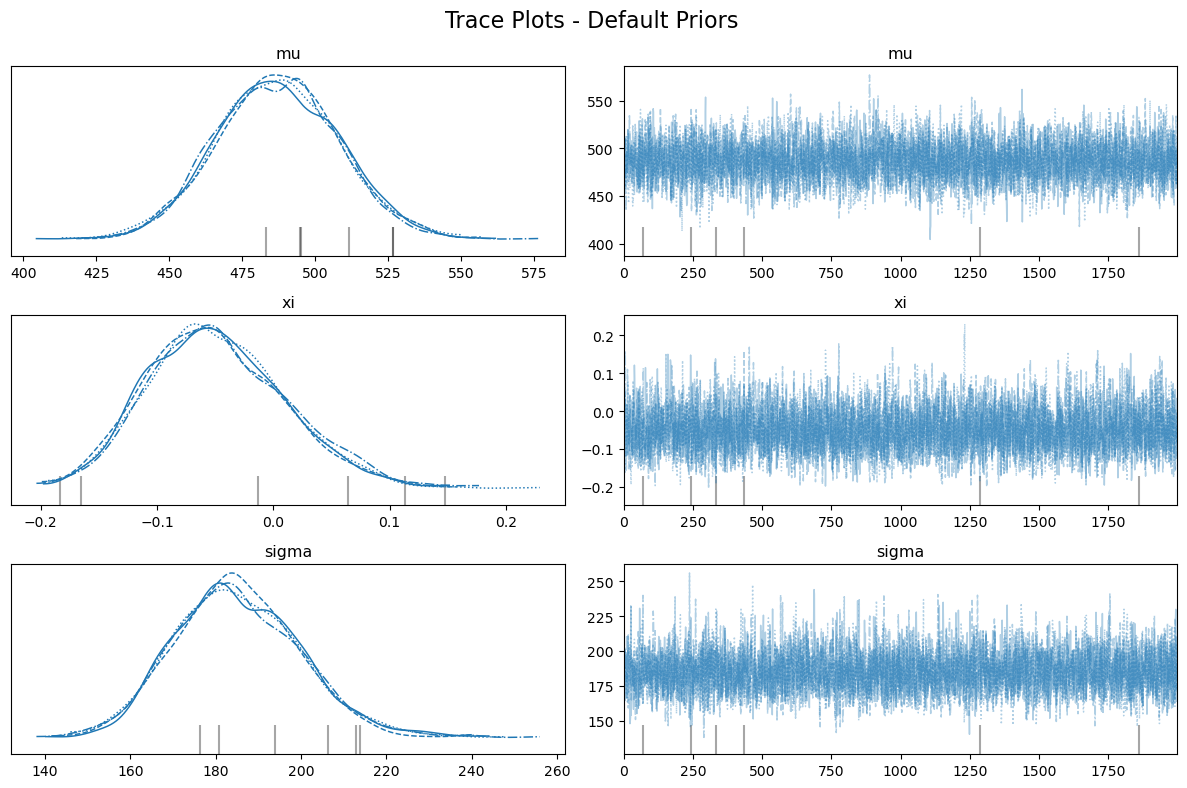

Summary for Default Priors priors:
          mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu     487.188  20.855  447.745  525.772      0.327    0.232    4085.0   
sigma  185.061  14.648  159.205  213.262      0.213    0.151    4729.0   
xi      -0.048   0.059   -0.155    0.065      0.001    0.001    4501.0   

       ess_tail  r_hat  
mu       4431.0    1.0  
sigma    4754.0    1.0  
xi       4255.0    1.0  


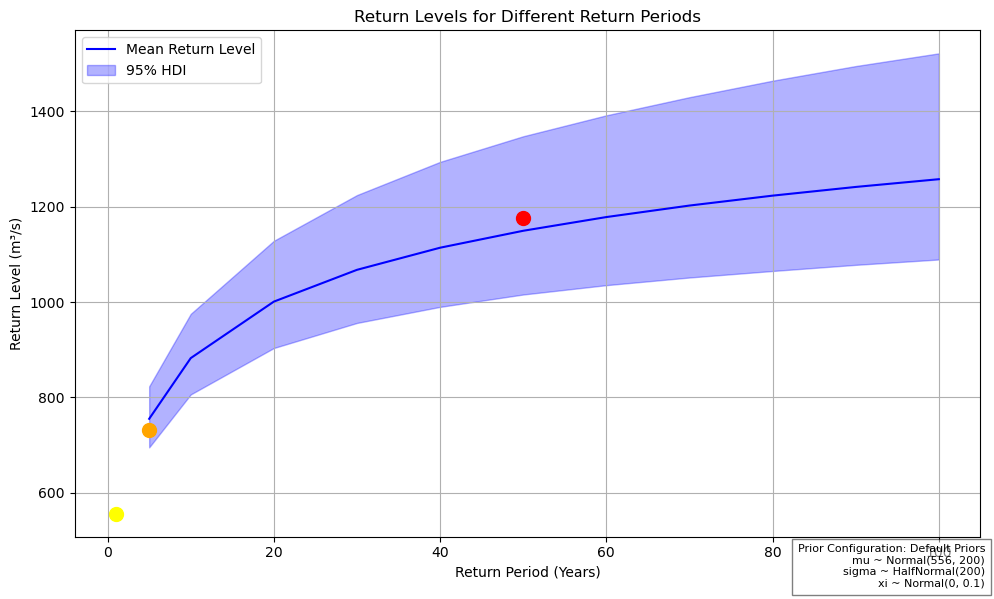

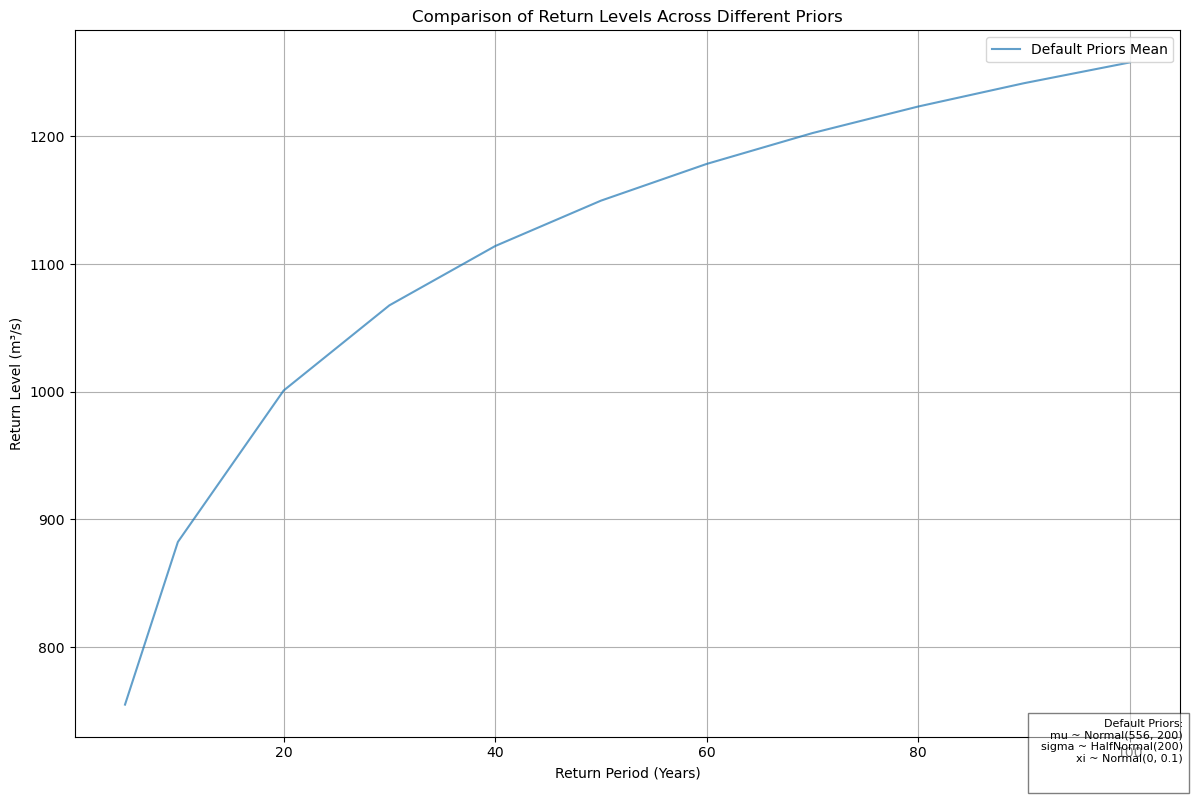


Comparison of Return Levels Across Different Priors:

Return Period: 5 years
  Default Priors: Mean = 755.07, 95% HDI = [695.16, 823.15] m³/s

Return Period: 10 years
  Default Priors: Mean = 882.46, 95% HDI = [806.27, 975.28] m³/s

Return Period: 20 years
  Default Priors: Mean = 1000.99, 95% HDI = [903.63, 1128.59] m³/s

Return Period: 30 years
  Default Priors: Mean = 1067.68, 95% HDI = [956.22, 1224.53] m³/s

Return Period: 40 years
  Default Priors: Mean = 1114.08, 95% HDI = [989.96, 1294.16] m³/s

Return Period: 50 years
  Default Priors: Mean = 1149.62, 95% HDI = [1015.90, 1347.92] m³/s

Return Period: 60 years
  Default Priors: Mean = 1178.39, 95% HDI = [1035.52, 1391.83] m³/s

Return Period: 70 years
  Default Priors: Mean = 1202.53, 95% HDI = [1051.57, 1429.90] m³/s

Return Period: 80 years
  Default Priors: Mean = 1223.33, 95% HDI = [1065.25, 1464.46] m³/s

Return Period: 90 years
  Default Priors: Mean = 1241.57, 95% HDI = [1078.12, 1495.19] m³/s

Return Period: 100 years


In [20]:
######## Heisel Station ##########

def main():
    # Configuration
    filepath = r'Heisel_Discharge.csv'  # Update this path as needed
    exclude_years = [2019, 2024]
    return_periods = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])  # Included 5-year return period
    alert_levels = {
        'yellow': 556,
        'orange': 731,
        'red': 1176
    }
    alert_periods = {
        'yellow': 1,
        'orange': 5,
        'red': 50
    }
    # Load and preprocess data
    annual_max_discharge = load_and_preprocess_data(filepath, exclude_years)

    # Define different prior configurations
    prior_sets = [
        (
            "Default Priors",
            {
                'mu': {'mu': 556, 'sigma': 200, 'initval': np.mean(annual_max_discharge)},
                'sigma': {'sigma': 200, 'initval': np.std(annual_max_discharge)},
                'xi': {'mu': 0, 'sigma': 0.1, 'initval': 0}
            }
        ),
        
    ]

    # Run models with different priors
    results = run_different_priors(annual_max_discharge, return_periods, prior_sets, alert_levels=alert_levels, alert_periods=alert_periods)

    # Plot comparison of return levels across different priors
    plot_comparative_return_levels(return_periods, results)

    # Print comparison of return levels
    print("\nComparison of Return Levels Across Different Priors:")
    for rp in return_periods:
        print(f"\nReturn Period: {rp} years")
        for prior_name, result in results.items():
            # Find the index where return_periods == rp
            idx = np.where(return_periods == rp)[0][0]
            mean_rl = result['return_levels']['mean'][idx]
            lb = result['return_levels']['hdi_lower'][idx]
            ub = result['return_levels']['hdi_upper'][idx]
            print(f"  {prior_name}: Mean = {mean_rl:.2f}, 95% HDI = [{lb:.2f}, {ub:.2f}] m³/s")

if __name__ == "__main__":
    main()


--- Running model with prior: Default Priors ---


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, xi]


Output()

Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 19 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


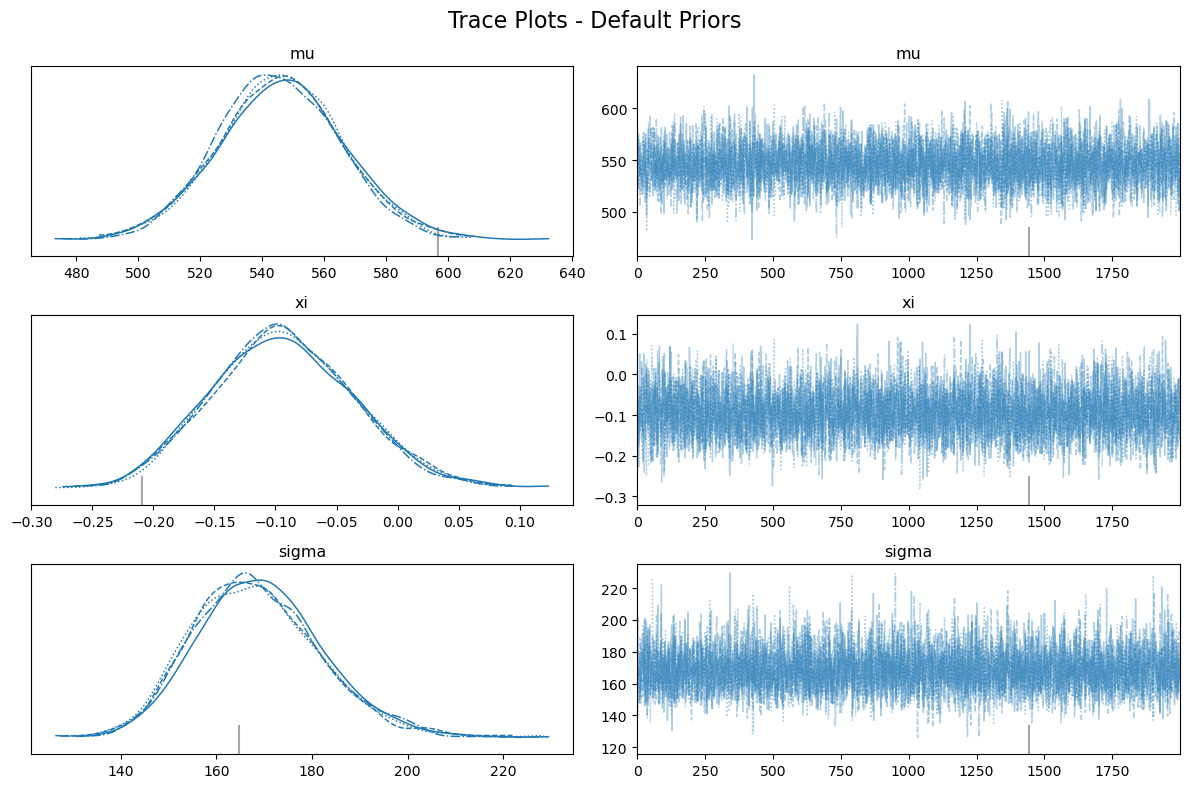

Summary for Default Priors priors:
          mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu     545.813  19.759  508.490  583.542      0.290    0.205    4648.0   
sigma  168.556  13.218  145.115  193.934      0.177    0.126    5587.0   
xi      -0.094   0.058   -0.198    0.017      0.001    0.001    4667.0   

       ess_tail  r_hat  
mu       4229.0    1.0  
sigma    5495.0    1.0  
xi       4899.0    1.0  


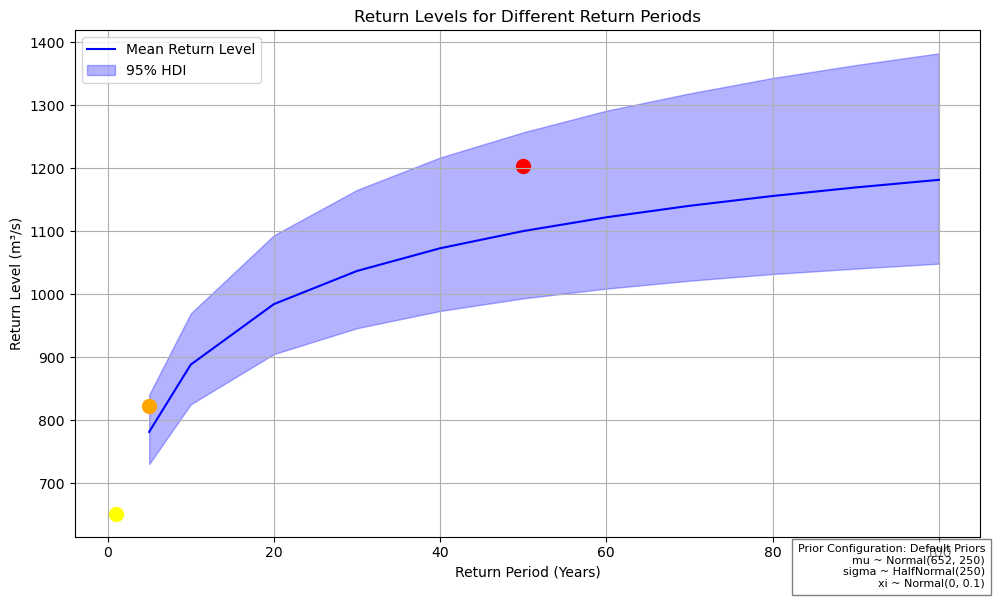

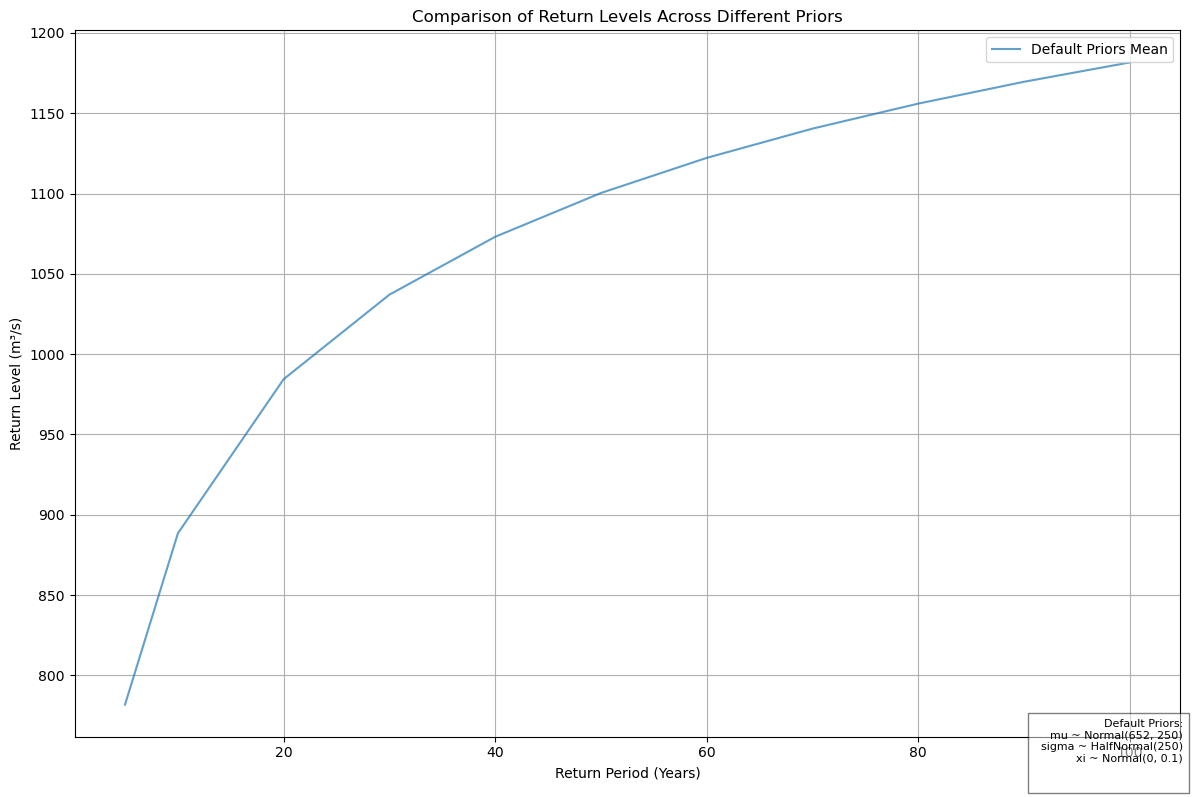


Comparison of Return Levels Across Different Priors:

Return Period: 5 years
  Default Priors: Mean = 781.84, 95% HDI = [730.70, 840.89] m³/s

Return Period: 10 years
  Default Priors: Mean = 888.47, 95% HDI = [825.41, 969.72] m³/s

Return Period: 20 years
  Default Priors: Mean = 984.43, 95% HDI = [905.12, 1093.63] m³/s

Return Period: 30 years
  Default Priors: Mean = 1037.04, 95% HDI = [946.22, 1165.66] m³/s

Return Period: 40 years
  Default Priors: Mean = 1073.06, 95% HDI = [973.57, 1217.01] m³/s

Return Period: 50 years
  Default Priors: Mean = 1100.32, 95% HDI = [993.54, 1257.00] m³/s

Return Period: 60 years
  Default Priors: Mean = 1122.18, 95% HDI = [1009.02, 1291.31] m³/s

Return Period: 70 years
  Default Priors: Mean = 1140.38, 95% HDI = [1021.53, 1318.69] m³/s

Return Period: 80 years
  Default Priors: Mean = 1155.96, 95% HDI = [1032.12, 1343.16] m³/s

Return Period: 90 years
  Default Priors: Mean = 1169.55, 95% HDI = [1040.71, 1363.69] m³/s

Return Period: 100 years
  

In [21]:
######## Barkald Station #######

def main():
    # Configuration
    filepath = r'Barkaldfoss.csv'  # Update this path as needed
    exclude_years = [1995, 2012, 2024]
    return_periods = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])  # Included 5-year return period
    alert_levels = {
        'yellow': 652,
        'orange': 823,
        'red': 1203
    }
    alert_periods = {
        'yellow': 1,
        'orange': 5,
        'red': 50
    }
    # Load and preprocess data
    annual_max_discharge = load_and_preprocess_data(filepath, exclude_years)

    # Define different prior configurations
    prior_sets = [
        (
            "Default Priors",
            {
                'mu': {'mu': 652, 'sigma': 250, 'initval': np.mean(annual_max_discharge)},
                'sigma': {'sigma': 250, 'initval': np.std(annual_max_discharge)},
                'xi': {'mu': 0, 'sigma': 0.1, 'initval': 0}
            }
        ),
        
    ]

    # Run models with different priors
    results = run_different_priors(annual_max_discharge, return_periods, prior_sets, alert_levels=alert_levels, alert_periods=alert_periods)

    # Plot comparison of return levels across different priors
    plot_comparative_return_levels(return_periods, results)

    # Print comparison of return levels
    print("\nComparison of Return Levels Across Different Priors:")
    for rp in return_periods:
        print(f"\nReturn Period: {rp} years")
        for prior_name, result in results.items():
            # Find the index where return_periods == rp
            idx = np.where(return_periods == rp)[0][0]
            mean_rl = result['return_levels']['mean'][idx]
            lb = result['return_levels']['hdi_lower'][idx]
            ub = result['return_levels']['hdi_upper'][idx]
            print(f"  {prior_name}: Mean = {mean_rl:.2f}, 95% HDI = [{lb:.2f}, {ub:.2f}] m³/s")

if __name__ == "__main__":
    main()